# Prediksi Curah Hujan – Machine Learning & Deep Learning Pipeline

Notebook ini berisi pipeline lengkap untuk prediksi curah hujan menggunakan berbagai model ML dan DL.

## 1. Install Dependencies Library

In [1]:
# # # # # Install dependencies
# !pip install -q "numpy<2.0" tensorflow==2.16.1
!pip install -q skl2onnx onnx onnxruntime tf2onnx onnxmltools xgboost==1.7.6

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.3/200.3 MB 5.5 MB/s eta 0:00:00


## 2. Import Library

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set plotting styles
plt.style.use('ggplot')
sns.set_style('whitegrid')

# ML Libraries
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
import joblib

# DL Libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

print('All libraries imported successfully!')
print(f'TensorFlow version: {tf.__version__}')
print(f'NumPy version: {np.__version__}')

All libraries imported successfully!
TensorFlow version: 2.19.0
NumPy version: 2.0.2


## 3. Load Dataset

In [3]:
# Load data dari Excel
df = pd.read_excel('Regresi-Hujan.xlsx', sheet_name='Data Hjan Harian')
df = df.loc[:, df.columns.notna()]

# Set proper column names
df.columns = df.iloc[2]
df = df.iloc[3:].reset_index(drop=True)

print(f'Shape: {df.shape}')
df.head()

Shape: (366, 22)


2,Tanggal,Bulan,2001.0,2002.0,2003.0,2004.0,2005.0,2006.0,2007.0,2008.0,...,2011.0,2012.0,2013.0,2014.0,2015.0,2016.0,2017.0,2018.0,2019.0,2020.0
0,1,Januari,1.090000,2.686667,5.053333,3.003333,3.003333,5.446667,7.100000,0.466667,...,1.220000,4.323333,-0.166667,0.486667,-0.383333,2.430000,1.140000,4.826667,5.300000,0.790000
1,2,Januari,1.066667,2.616667,5.070000,3.140000,3.140000,4.990000,7.100000,2.040000,...,2.076667,5.583333,1.336667,-0.193333,1.006667,1.263333,0.526667,6.880000,4.586667,0.900000
2,3,Januari,1.126667,2.516667,6.180000,3.256667,3.256667,4.626667,7.100000,2.656667,...,5.776667,7.100000,1.553333,-0.273333,-0.043333,0.153333,3.526667,5.980000,4.726667,2.440000
3,4,Januari,1.140000,2.463333,6.050000,3.270000,3.270000,4.783333,7.100000,1.373333,...,5.693333,7.100000,2.230000,0.000000,2.290000,0.116667,5.200000,5.226667,3.216667,0.136667
4,5,Januari,1.150000,2.476667,4.743333,3.206667,3.206667,6.826667,6.973333,1.900000,...,4.050000,6.700000,3.933333,-0.053333,1.260000,0.200000,8.016667,4.600000,1.173333,-1.056667


## 4. Exploratory Data Analysis (EDA)

### 4.1 Struktur dan Info Data

In [4]:
print('=== INFO DATA ===')
print(f'Jumlah Baris: {df.shape[0]}')
print(f'Jumlah Kolom: {df.shape[1]}')
print(f'\nKolom: {list(df.columns)}')
print(f'\nTipe Data:')
print(df.dtypes)

=== INFO DATA ===
Jumlah Baris: 366
Jumlah Kolom: 22

Kolom: ['Tanggal', 'Bulan', np.float64(2001.0), np.float64(2002.0), np.float64(2003.0), np.float64(2004.0), np.float64(2005.0), np.float64(2006.0), np.float64(2007.0), np.float64(2008.0), np.float64(2009.0), np.float64(2010.0), np.float64(2011.0), np.float64(2012.0), np.float64(2013.0), np.float64(2014.0), np.float64(2015.0), np.float64(2016.0), np.float64(2017.0), np.float64(2018.0), np.float64(2019.0), np.float64(2020.0)]

Tipe Data:
2
Tanggal     object
Bulan       object
2001.0     float64
2002.0     float64
2003.0     float64
2004.0     float64
2005.0     float64
2006.0     float64
2007.0     float64
2008.0     float64
2009.0     float64
2010.0     float64
2011.0     float64
2012.0     float64
2013.0     float64
2014.0     float64
2015.0     float64
2016.0     float64
2017.0     float64
2018.0     float64
2019.0     float64
2020.0     float64
dtype: object


### 4.2 Statistik Deskriptif

In [5]:
# Kolom tahun (numerik)
year_cols = df.columns[2:]
df[year_cols] = df[year_cols].apply(pd.to_numeric, errors='coerce')
df[year_cols] = df[year_cols].clip(lower=0)

df[year_cols].describe()

2,2001.0,2002.0,2003.0,2004.0,2005.0,2006.0,2007.0,2008.0,2009.0,2010.0,2011.0,2012.0,2013.0,2014.0,2015.0,2016.0,2017.0,2018.0,2019.0,2020.0
count,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000
mean,2.520622,1.866148,1.989818,1.825304,1.825304,2.230546,1.638702,1.306393,2.639800,2.011405,1.439007,1.738291,0.850738,1.172450,1.817987,1.711630,2.104936,0.975483,1.221667,1.124690
std,1.765583,1.940714,2.139548,1.972433,1.972433,2.124508,2.104004,1.929048,1.899687,1.773971,1.470825,2.081944,1.286606,1.896230,1.947913,2.168726,2.548490,1.530600,1.648456,1.434901
min,0.000000,0.000000,0.000000,0.004000,0.004000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.006667,0.017250,0.000000,0.063667,0.063667,0.321667,0.000000,0.000000,1.113333,0.730000,0.332500,0.000000,0.000000,0.000000,0.315000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.425000,1.548333,1.026667,1.003333,1.003333,1.015000,0.671667,0.056667,2.580000,1.241667,0.930000,0.793333,0.000000,0.000000,1.126667,0.208333,1.646667,0.020000,0.000000,0.428333
75%,3.767500,3.594167,4.035000,3.079167,3.079167,4.305000,2.977500,2.122500,3.889167,3.251667,2.088333,3.126667,1.562500,2.312500,2.585000,3.261667,3.163333,1.459167,2.198333,1.944167
max,7.286667,7.400000,6.616667,7.406667,7.406667,7.133333,7.100000,7.790000,7.473333,7.270000,7.130000,7.100000,5.616667,6.856667,7.706667,7.500000,11.010000,7.063333,6.003333,5.933333


### 4.3 Transformasi ke Format Long

In [6]:
# Melt ke format long untuk analisis time series
df_long = df.melt(
    id_vars=['Tanggal', 'Bulan'],
    var_name='tahun',
    value_name='hujan'
)
df_long['tahun'] = df_long['tahun'].astype(int)

# Buat kolom tanggal
df_long['tanggal'] = pd.to_datetime(
    df_long['tahun'].astype(str) + '-' +
    df_long['Bulan'].astype(str) + '-' +
    df_long['Tanggal'].astype(str),
    errors='coerce'
)

df_long = df_long.dropna(subset=['tanggal', 'hujan'])
df_long = df_long.sort_values('tanggal').reset_index(drop=True)

print(f'Data setelah transformasi: {df_long.shape}')
df_long.head(10)

Data setelah transformasi: (1800, 5)


,Tanggal,Bulan,tahun,hujan,tanggal
0,1,April,2001,5.393333,2001-04-01
1,2,April,2001,5.493333,2001-04-02
2,3,April,2001,5.610000,2001-04-03
3,4,April,2001,5.483333,2001-04-04
4,5,April,2001,5.540000,2001-04-05
5,6,April,2001,5.560000,2001-04-06
6,7,April,2001,5.440000,2001-04-07
7,8,April,2001,4.806667,2001-04-08
8,9,April,2001,4.656667,2001-04-09
9,10,April,2001,4.716667,2001-04-10


### 4.4 Distribusi Curah Hujan

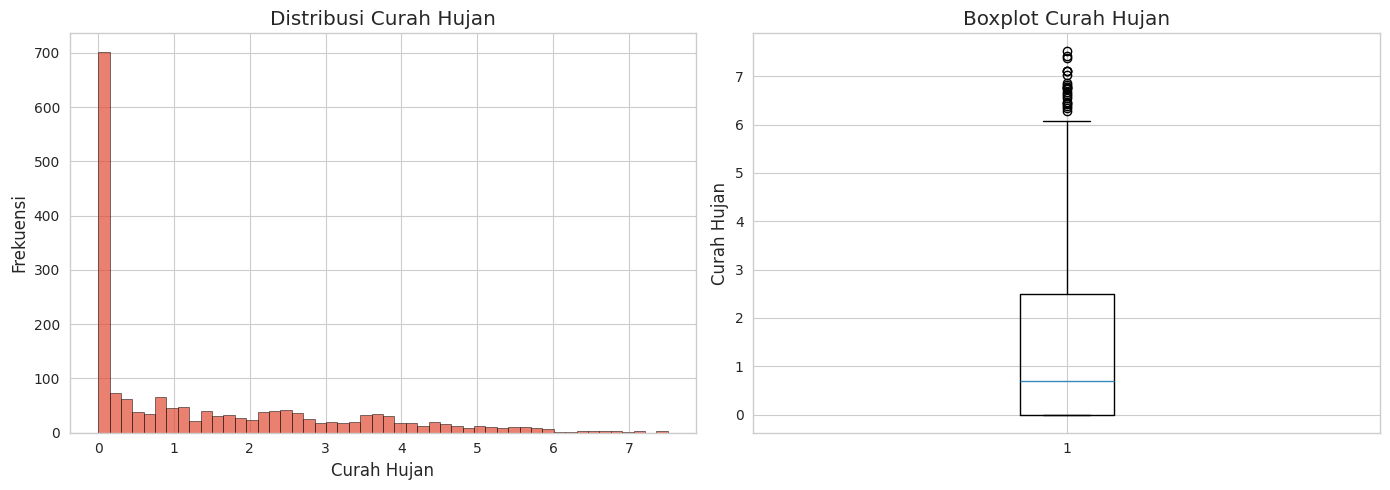

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
axes[0].hist(df_long['hujan'], bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Curah Hujan')
axes[0].set_ylabel('Frekuensi')
axes[0].set_title('Distribusi Curah Hujan')

# Boxplot
axes[1].boxplot(df_long['hujan'].dropna())
axes[1].set_ylabel('Curah Hujan')
axes[1].set_title('Boxplot Curah Hujan')

plt.tight_layout()
plt.show()

### 4.5 Time Series Plot

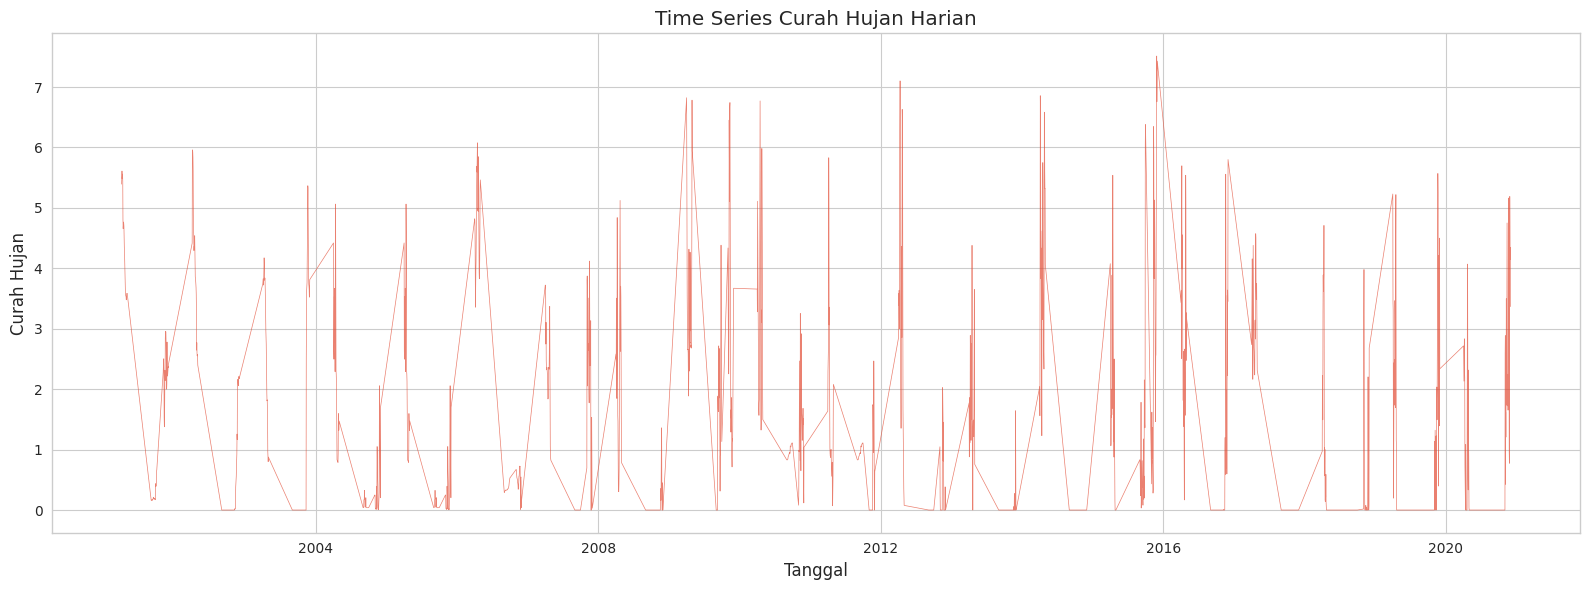

In [8]:
plt.figure(figsize=(16, 6))
plt.plot(df_long['tanggal'], df_long['hujan'], linewidth=0.5, alpha=0.7)
plt.xlabel('Tanggal')
plt.ylabel('Curah Hujan')
plt.title('Time Series Curah Hujan Harian')
plt.tight_layout()
plt.show()

### 4.6 Seasonal Analysis (Per Bulan)

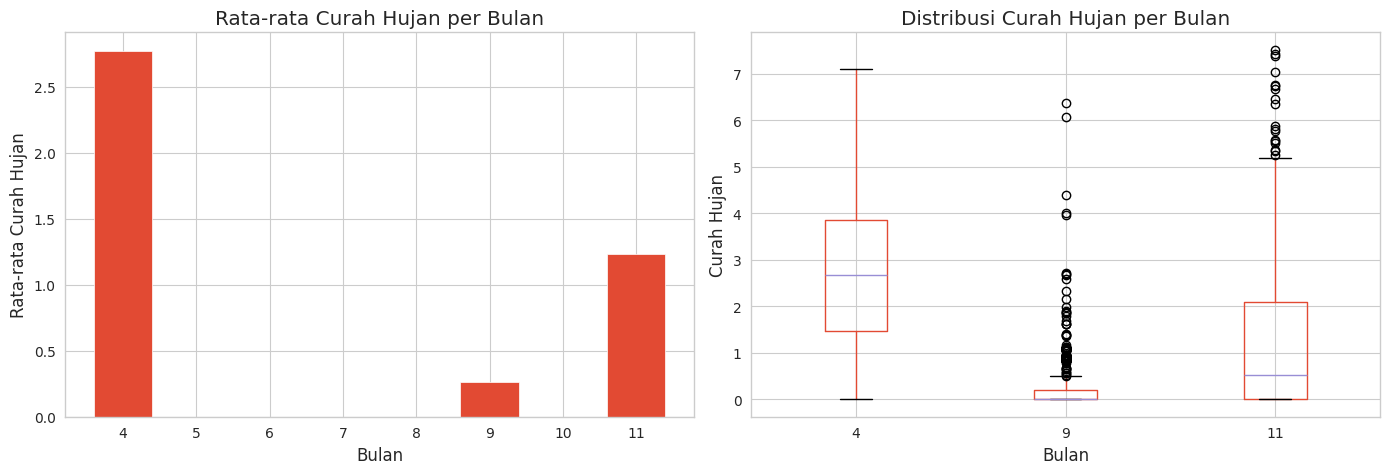

In [9]:
df_long['bulan_num'] = df_long['tanggal'].dt.month

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Mean per bulan
monthly_mean = df_long.groupby('bulan_num')['hujan'].mean()
axes[0].bar(monthly_mean.index, monthly_mean.values)
axes[0].set_xlabel('Bulan')
axes[0].set_ylabel('Rata-rata Curah Hujan')
axes[0].set_title('Rata-rata Curah Hujan per Bulan')

# Boxplot per bulan
df_long.boxplot(column='hujan', by='bulan_num', ax=axes[1])
axes[1].set_xlabel('Bulan')
axes[1].set_ylabel('Curah Hujan')
plt.suptitle('')
axes[1].set_title('Distribusi Curah Hujan per Bulan')

plt.tight_layout()
plt.show()

### 4.7 Yearly Trends

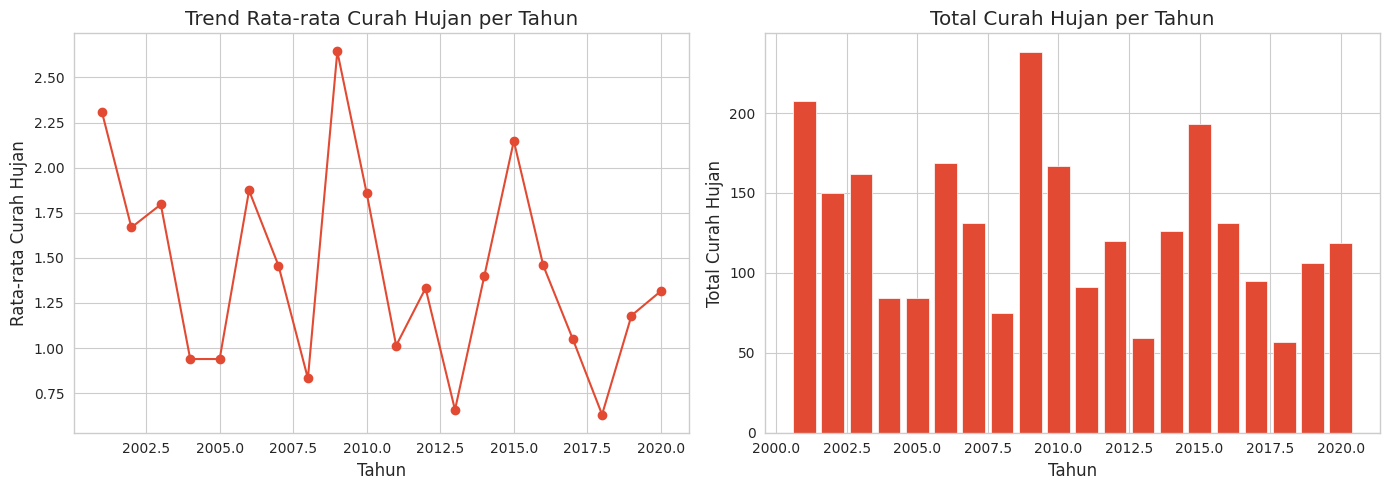

In [10]:
yearly_stats = df_long.groupby('tahun')['hujan'].agg(['mean', 'std', 'sum'])

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(yearly_stats.index, yearly_stats['mean'], marker='o')
axes[0].set_xlabel('Tahun')
axes[0].set_ylabel('Rata-rata Curah Hujan')
axes[0].set_title('Trend Rata-rata Curah Hujan per Tahun')

axes[1].bar(yearly_stats.index, yearly_stats['sum'])
axes[1].set_xlabel('Tahun')
axes[1].set_ylabel('Total Curah Hujan')
axes[1].set_title('Total Curah Hujan per Tahun')

plt.tight_layout()
plt.show()

### 4.8 Missing Values Analysis

In [11]:
print('=== MISSING VALUES ===')
print(f'Total missing values: {df_long["hujan"].isna().sum()}')
print(f'Persentase missing: {df_long["hujan"].isna().mean()*100:.2f}%')
print(f'\nTotal data points: {len(df_long)}')

=== MISSING VALUES ===
Total missing values: 0
Persentase missing: 0.00%

Total data points: 1800


## 5. Data Preprocessing

### 5.1 Data Cleaning

In [12]:
# Hapus missing values
df_clean = df_long.dropna(subset=['hujan']).copy()
print(f'Data setelah cleaning: {len(df_clean)} rows')

Data setelah cleaning: 1800 rows


### 5.2 Feature Engineering - Lag Features

In [13]:
# Lag features
df_clean['lag_1'] = df_clean['hujan'].shift(1)
df_clean['lag_3'] = df_clean['hujan'].shift(3)
df_clean['lag_7'] = df_clean['hujan'].shift(7)

print('Lag features created: lag_1, lag_3, lag_7')

Lag features created: lag_1, lag_3, lag_7


### 5.3 Feature Engineering - Rolling Statistics

In [14]:
# Rolling statistics
df_clean['roll_mean_3'] = df_clean['hujan'].rolling(3).mean()
df_clean['roll_mean_7'] = df_clean['hujan'].rolling(7).mean()
df_clean['roll_max_7'] = df_clean['hujan'].rolling(7).max()
df_clean['roll_std_7'] = df_clean['hujan'].rolling(7).std()

print('Rolling features created: roll_mean_3, roll_mean_7, roll_max_7, roll_std_7')

Rolling features created: roll_mean_3, roll_mean_7, roll_max_7, roll_std_7


### 5.4 Feature Engineering - Time Features

In [15]:
# Time features
df_clean['bulan_idx'] = df_clean['tanggal'].dt.month
df_clean['day_of_week'] = df_clean['tanggal'].dt.dayofweek
df_clean['day_of_year'] = df_clean['tanggal'].dt.dayofyear

# Hapus rows dengan NaN dari feature engineering
df_clean = df_clean.dropna()

print(f'Data setelah feature engineering: {len(df_clean)} rows')
df_clean.head()

Data setelah feature engineering: 1793 rows


,Tanggal,Bulan,tahun,hujan,tanggal,bulan_num,lag_1,lag_3,lag_7,roll_mean_3,roll_mean_7,roll_max_7,roll_std_7,bulan_idx,day_of_week,day_of_year
7,8,April,2001,4.806667,2001-04-08,4,5.440000,5.540000,5.393333,5.268889,5.419048,5.61,0.275699,4,6,98
8,9,April,2001,4.656667,2001-04-09,4,4.806667,5.560000,5.493333,4.967778,5.299524,5.61,0.394074,4,0,99
9,10,April,2001,4.716667,2001-04-10,4,4.656667,5.440000,5.610000,4.726667,5.171905,5.56,0.420533,4,1,100
10,11,April,2001,4.766667,2001-04-11,4,4.716667,4.806667,5.483333,4.713333,5.069524,5.56,0.419313,4,2,101
11,12,April,2001,4.743333,2001-04-12,4,4.766667,4.656667,5.540000,4.742222,4.955714,5.56,0.376237,4,3,102


### 5.5 Train-Test Split (untuk ML Tabular)

In [16]:
FEATURES = [
    'lag_1', 'lag_3', 'lag_7',
    'roll_mean_3', 'roll_mean_7', 'roll_max_7', 'roll_std_7',
    'bulan_idx', 'day_of_week'
]

X = df_clean[FEATURES]
y = df_clean['hujan']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

feature_scaler = StandardScaler()
X_train_scaled = feature_scaler.fit_transform(X_train)
X_test_scaled = feature_scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=FEATURES, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=FEATURES, index=X_test.index)

print(f'Training set: {len(X_train)} samples')
print(f'Test set: {len(X_test)} samples')
print(f'Feature scaler fitted: mean={feature_scaler.mean_[:3]}, scale={feature_scaler.scale_[:3]}')

Training set: 1434 samples
Test set: 359 samples
Feature scaler fitted: mean=[1.50347768 1.50476778 1.51218061], scale=[1.74531285 1.74740875 1.75818509]


### 5.6 Sequence Preparation (untuk LSTM/BiLSTM)

In [17]:
SEQ_LEN = 7

target_scaler = StandardScaler()
series_raw = df_clean['hujan'].values.reshape(-1, 1).astype(np.float32)
series_scaled = target_scaler.fit_transform(series_raw).ravel()

print(f'Target scaler fitted: mean={target_scaler.mean_[0]:.4f}, scale={target_scaler.scale_[0]:.4f}')

def make_sequences(series, seq_len):
    X, y = [], []
    for i in range(len(series) - seq_len):
        X.append(series[i:i+seq_len])
        y.append(series[i+seq_len])
    return np.array(X), np.array(y)

X_seq, y_seq = make_sequences(series_scaled, SEQ_LEN)

X_tr, X_te, y_tr, y_te = train_test_split(
    X_seq, y_seq, test_size=0.2, shuffle=False
)

X_tr = X_tr[..., np.newaxis].astype(np.float32)
X_te = X_te[..., np.newaxis].astype(np.float32)

print(f'Sequence shape - Train: {X_tr.shape}, Test: {X_te.shape}')

Target scaler fitted: mean=1.4092, scale=1.7061
Sequence shape - Train: (1428, 7, 1), Test: (358, 7, 1)


## 6. Model Building

### 6.1 Scikit-Learn Models

In [18]:
# Linear Regression
lr_model = LinearRegression()

# Gradient Boosting Regressor (ONNX-compatible)
gbr_model = GradientBoostingRegressor(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    random_state=42
)

# XGBoost Regressor (ONNX-compatible)
xgb_model = XGBRegressor(
    n_estimators=200,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    base_score=0.5,  # Fixed value - required for ONNX compatibility
    booster='gbtree'  # Ensure tree-based booster for ONNX
)

print('Scikit-Learn models defined: LinearRegression, GradientBoostingRegressor, XGBRegressor')

Scikit-Learn models defined: LinearRegression, GradientBoostingRegressor, XGBRegressor


### 6.2 Deep Learning Models

In [19]:
def build_lstm(seq_len):
    model = Sequential([
        LSTM(
            units=32,
            input_shape=(seq_len, 1),
            activation="tanh",
            recurrent_activation="sigmoid",
            unroll=True,
            return_sequences=False
        ),
        Dense(1)
    ])
    model.compile(
        optimizer="adam",
        loss="mse",
        metrics=["mae"]
    )
    return model


def build_bilstm(seq_len):
    model = Sequential([
        Bidirectional(
            LSTM(
                units=32,
                activation="tanh",
                recurrent_activation="sigmoid",
                unroll=True,
                return_sequences=False
            ),
            input_shape=(seq_len, 1)
        ),
        Dense(1)
    ])
    model.compile(
        optimizer="adam",
        loss="mse",
        metrics=["mae"]
    )
    return model


# Build models
lstm_model = build_lstm(SEQ_LEN)
bilstm_model = build_bilstm(SEQ_LEN)

print("✅ Static LSTM & BiLSTM models created (ONNX-compatible)")
lstm_model.summary()

✅ Static LSTM & BiLSTM models created (ONNX-compatible)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 32)             │         4,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,385 (17.13 KB)

 Trainable params: 4,385 (17.13 KB)

 Non-trainable params: 0 (0.00 B)

## 7. Callbacks untuk TensorFlow

In [20]:
# Early Stopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

# Model Checkpoint - LSTM
checkpoint_lstm = ModelCheckpoint(
    'best_lstm.keras',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# Model Checkpoint - BiLSTM
checkpoint_bilstm = ModelCheckpoint(
    'best_bilstm.keras',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# Learning Rate Scheduler
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

print('Callbacks defined: EarlyStopping, ModelCheckpoint, ReduceLROnPlateau')

Callbacks defined: EarlyStopping, ModelCheckpoint, ReduceLROnPlateau


## 8. Model Training

### 8.1 Training Scikit-Learn Models

In [36]:
# Linear Regression (using SCALED features)
lr_model.fit(X_train_scaled, y_train)
print('Linear Regression trained!')

# Gradient Boosting (using SCALED features)
gbr_model.fit(X_train_scaled, y_train)
print('Gradient Boosting trained!')

# XGBoost (using SCALED features as numpy array for ONNX compatibility)
xgb_model.fit(X_train_scaled.values, y_train.values)
print('XGBoost trained!')

Linear Regression trained!
Gradient Boosting trained!
XGBoost trained!


### 8.2 Training Deep Learning Models

In [22]:
EPOCHS = 50
BATCH_SIZE = 32

# Training LSTM
print('\n=== Training LSTM ===')
history_lstm = lstm_model.fit(
    X_tr, y_tr,
    validation_split=0.2,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stop, checkpoint_lstm, lr_scheduler],
    verbose=1
)


=== Training LSTM ===
Epoch 1/50
30/36 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.9474 - mae: 0.8045
Epoch 1: val_loss improved from inf to 0.89459, saving model to best_lstm.keras
36/36 ━━━━━━━━━━━━━━━━━━━━ 7s 72ms/step - loss: 0.9121 - mae: 0.7849 - val_loss: 0.8946 - val_mae: 0.6880 - learning_rate: 0.0010
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.4484 - mae: 0.4766
Epoch 2: val_loss improved from 0.89459 to 0.80077, saving model to best_lstm.keras
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.4482 - mae: 0.4761 - val_loss: 0.8008 - val_mae: 0.5872 - learning_rate: 0.0010
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.3972 - mae: 0.4236
Epoch 3: val_loss improved from 0.80077 to 0.72191, saving model to best_lstm.keras
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.3968 - mae: 0.4233 - val_loss: 0.7219 - val_mae: 0.5600 - learning_rate: 0.0010
Epoch 4/50
35/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4011 - mae: 0.4109
Epoch 4: val_loss imp

In [23]:
# Rebuild BiLSTM (karena early stopping)
bilstm_model = build_bilstm(SEQ_LEN)

# Training BiLSTM
print('\n=== Training BiLSTM ===')
history_bilstm = bilstm_model.fit(
    X_tr, y_tr,
    validation_split=0.2,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stop, checkpoint_bilstm, lr_scheduler],
    verbose=1
)


=== Training BiLSTM ===
Epoch 1/50
30/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.6579 - mae: 0.6507
Epoch 1: val_loss improved from inf to 0.74345, saving model to best_bilstm.keras
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 0.6275 - mae: 0.6259 - val_loss: 0.7434 - val_mae: 0.5487 - learning_rate: 0.0010
Epoch 2/50
32/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3904 - mae: 0.3732
Epoch 2: val_loss improved from 0.74345 to 0.62938, saving model to best_bilstm.keras
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.3831 - mae: 0.3715 - val_loss: 0.6294 - val_mae: 0.5084 - learning_rate: 0.0010
Epoch 3/50
32/36 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.3528 - mae: 0.3618
Epoch 3: val_loss improved from 0.62938 to 0.55934, saving model to best_bilstm.keras
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.3446 - mae: 0.3586 - val_loss: 0.5593 - val_mae: 0.4683 - learning_rate: 0.0010
Epoch 4/50
34/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3003 - mae: 0.3396
Epoch 4: val_lo

## 9. Evaluation

### 9.1 Visualisasi Training Loss

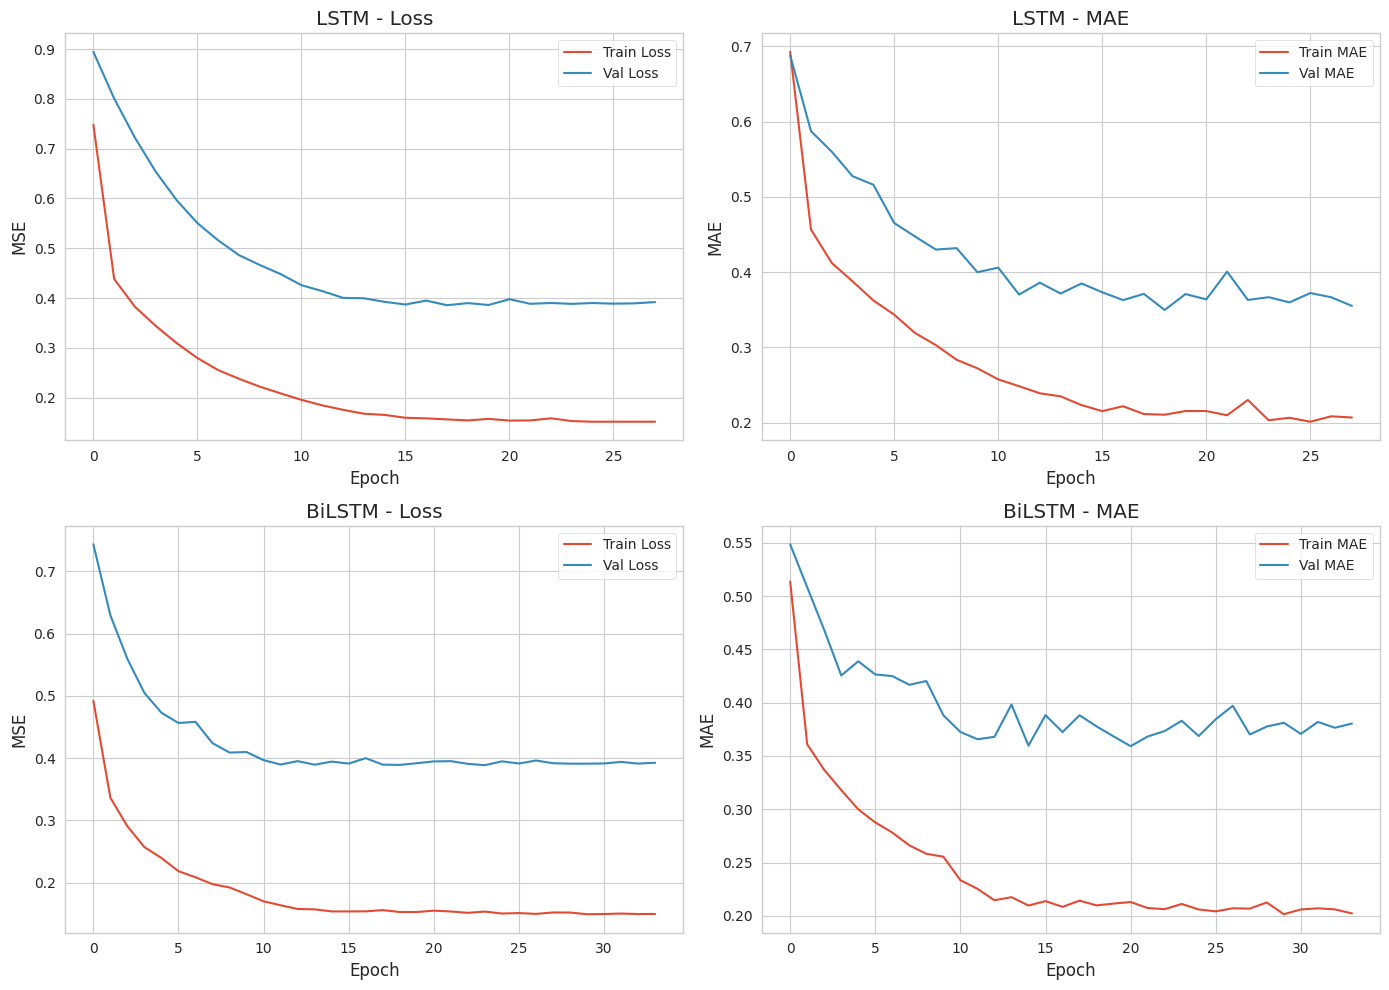

In [24]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# LSTM Loss
axes[0, 0].plot(history_lstm.history['loss'], label='Train Loss')
axes[0, 0].plot(history_lstm.history['val_loss'], label='Val Loss')
axes[0, 0].set_title('LSTM - Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('MSE')
axes[0, 0].legend()

# LSTM MAE
axes[0, 1].plot(history_lstm.history['mae'], label='Train MAE')
axes[0, 1].plot(history_lstm.history['val_mae'], label='Val MAE')
axes[0, 1].set_title('LSTM - MAE')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('MAE')
axes[0, 1].legend()

# BiLSTM Loss
axes[1, 0].plot(history_bilstm.history['loss'], label='Train Loss')
axes[1, 0].plot(history_bilstm.history['val_loss'], label='Val Loss')
axes[1, 0].set_title('BiLSTM - Loss')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('MSE')
axes[1, 0].legend()

# BiLSTM MAE
axes[1, 1].plot(history_bilstm.history['mae'], label='Train MAE')
axes[1, 1].plot(history_bilstm.history['val_mae'], label='Val MAE')
axes[1, 1].set_title('BiLSTM - MAE')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('MAE')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

### 9.2 Model Comparison Metrics

In [37]:
def evaluate_model(name, y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return {'Model': name, 'MAE': mae, 'MSE': mse, 'RMSE': rmse, 'R2': r2}

results = []

# Evaluate ML models (using SCALED features)
results.append(evaluate_model('Linear Regression', y_test, lr_model.predict(X_test_scaled)))
results.append(evaluate_model('Gradient Boosting', y_test, gbr_model.predict(X_test_scaled)))
results.append(evaluate_model('XGBoost', y_test, xgb_model.predict(X_test_scaled.values)))

# Evaluate DL models (need INVERSE TRANSFORM because trained on scaled data)
pred_lstm_scaled = lstm_model.predict(X_te).ravel()
pred_bilstm_scaled = bilstm_model.predict(X_te).ravel()
pred_lstm = target_scaler.inverse_transform(pred_lstm_scaled.reshape(-1, 1)).ravel()
pred_bilstm = target_scaler.inverse_transform(pred_bilstm_scaled.reshape(-1, 1)).ravel()
y_te_original = target_scaler.inverse_transform(y_te.reshape(-1, 1)).ravel()

results.append(evaluate_model('LSTM', y_te_original, pred_lstm))
results.append(evaluate_model('BiLSTM', y_te_original, pred_bilstm))

results_df = pd.DataFrame(results)
print('=== MODEL COMPARISON ===')
results_df

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
=== MODEL COMPARISON ===


,Model,MAE,MSE,RMSE,R2
0,Linear Regression,0.299395,0.275139,0.524537,0.877120
1,Gradient Boosting,0.286487,0.292256,0.540607,0.869475
2,XGBoost,0.311587,0.285449,0.534275,0.872515
3,LSTM,0.456923,0.591048,0.768796,0.735357
4,BiLSTM,0.457181,0.571925,0.756257,0.743919


### 9.3 Prediction vs Actual Plot

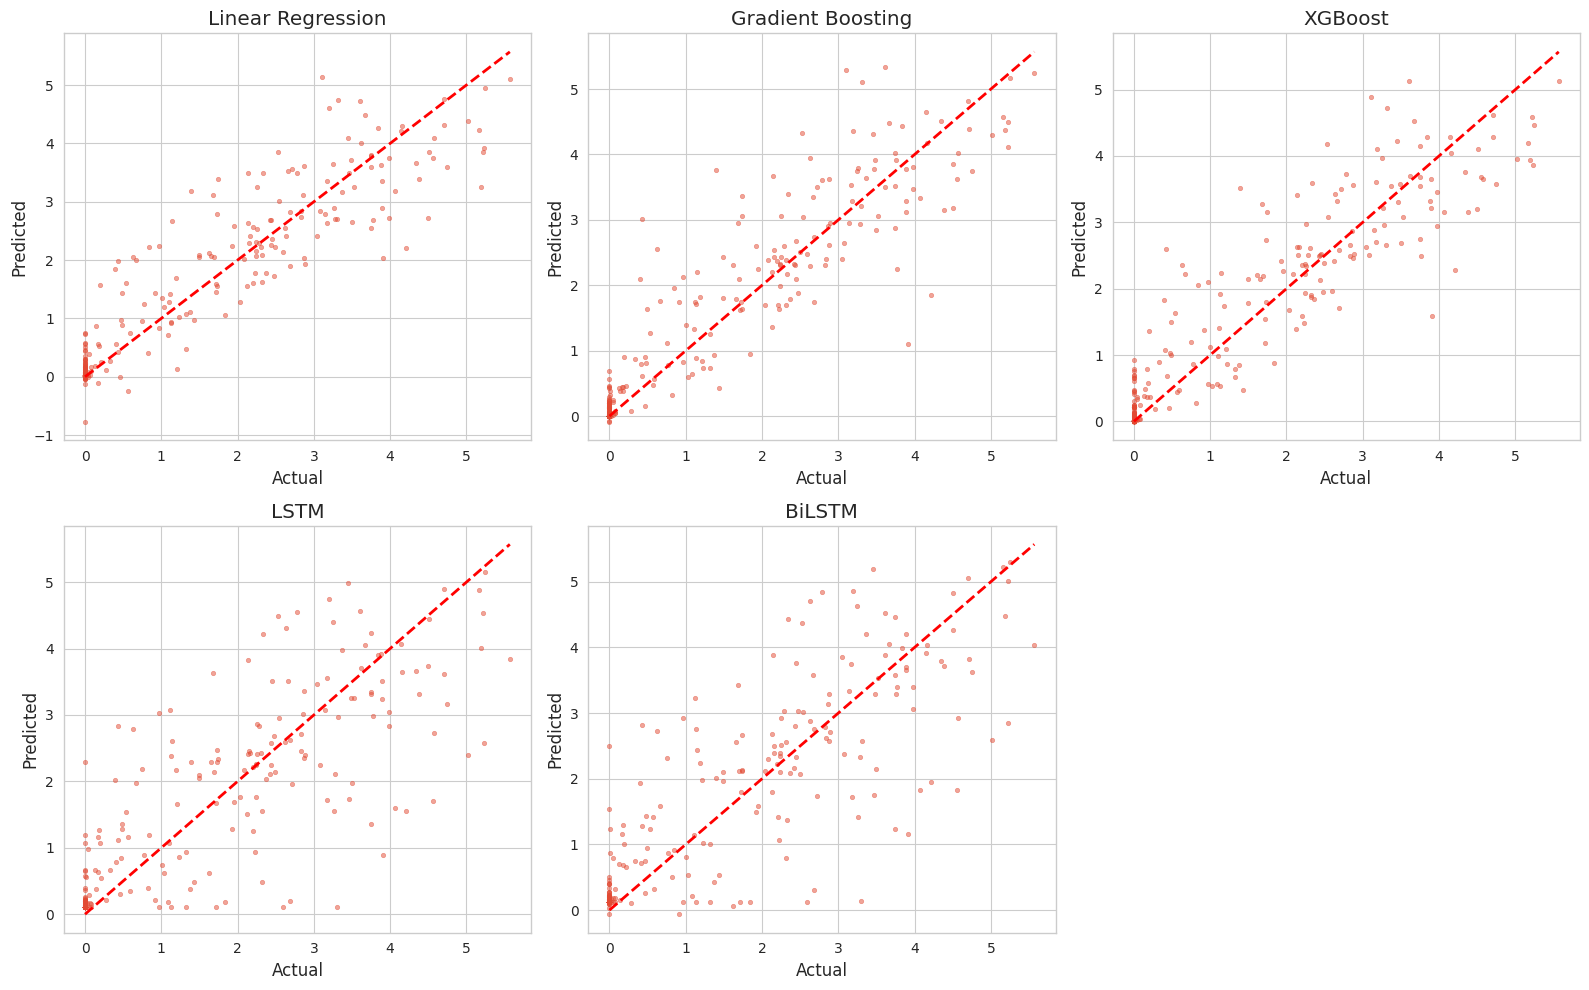

In [38]:
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

models = [
    ('Linear Regression', lr_model.predict(X_test_scaled), y_test),
    ('Gradient Boosting', gbr_model.predict(X_test_scaled), y_test),
    ('XGBoost', xgb_model.predict(X_test_scaled.values), y_test),
    ('LSTM', pred_lstm, y_te_original),
    ('BiLSTM', pred_bilstm, y_te_original),
]

for idx, (name, pred, actual) in enumerate(models):
    ax = axes.flatten()[idx]
    ax.scatter(actual, pred, alpha=0.5, s=10)
    ax.plot([actual.min(), actual.max()], [actual.min(), actual.max()], 'r--', lw=2)
    ax.set_xlabel('Actual')
    ax.set_ylabel('Predicted')
    ax.set_title(f'{name}')

axes.flatten()[-1].axis('off')
plt.tight_layout()
plt.show()

### 9.4 Residual Analysis

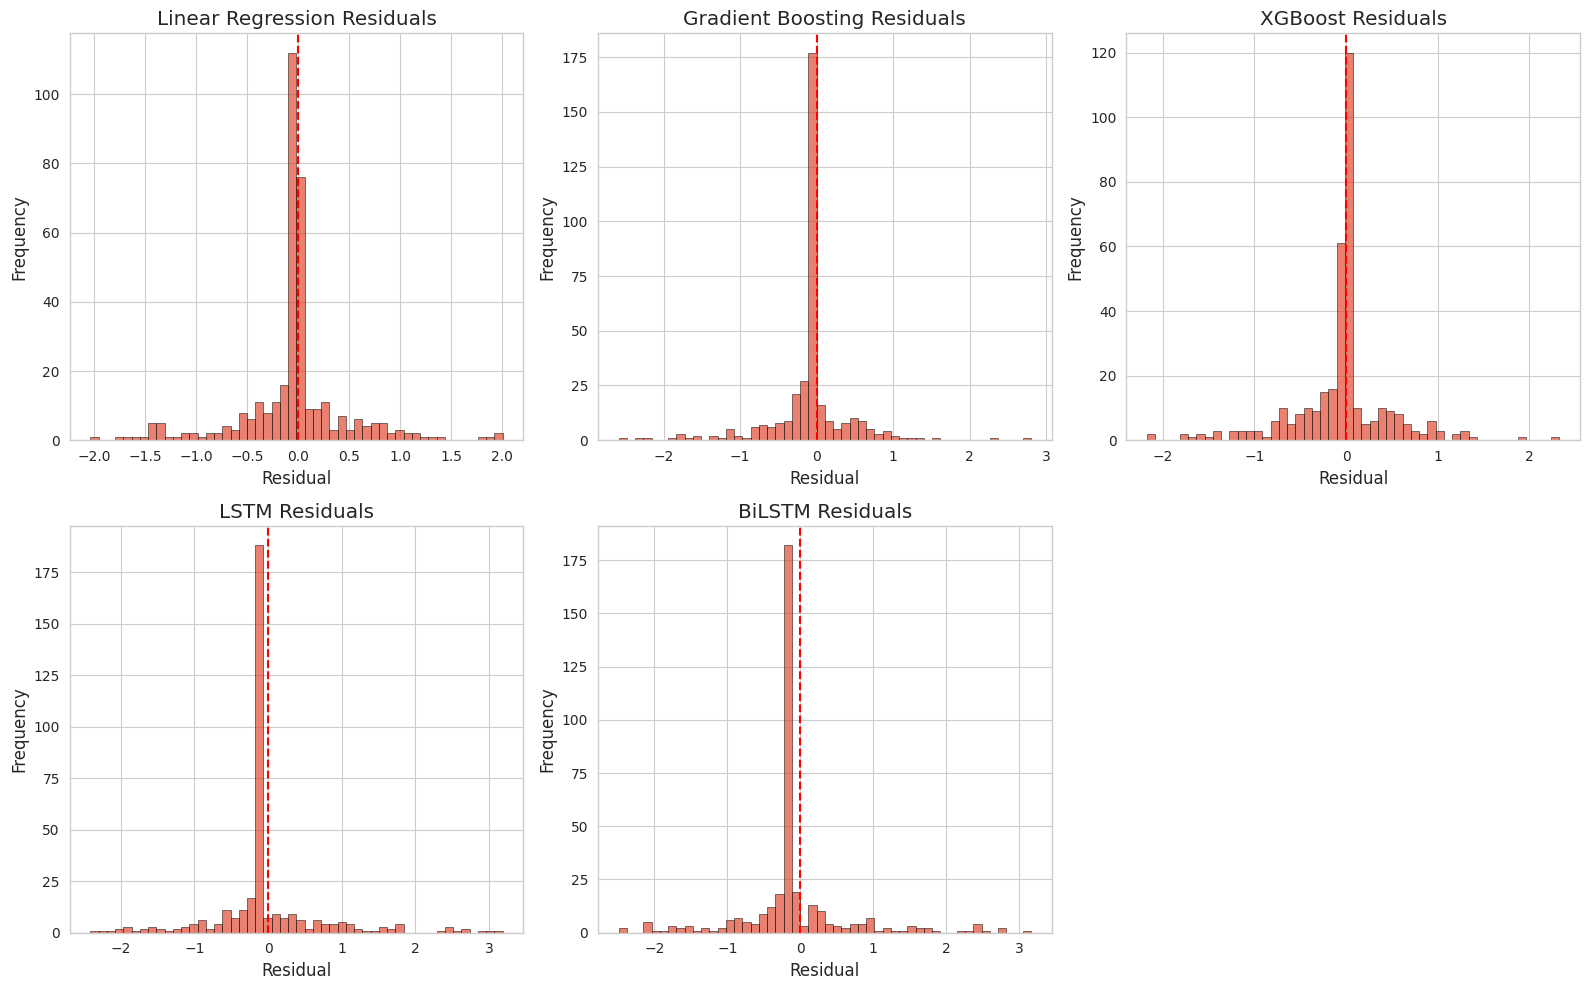

In [27]:
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

for idx, (name, pred, actual) in enumerate(models):
    ax = axes.flatten()[idx]
    residuals = actual - pred
    ax.hist(residuals, bins=50, edgecolor='black', alpha=0.7)
    ax.axvline(x=0, color='r', linestyle='--')
    ax.set_xlabel('Residual')
    ax.set_ylabel('Frequency')
    ax.set_title(f'{name} Residuals')

axes.flatten()[-1].axis('off')
plt.tight_layout()
plt.show()

### 9.5 Actual VS Predicted

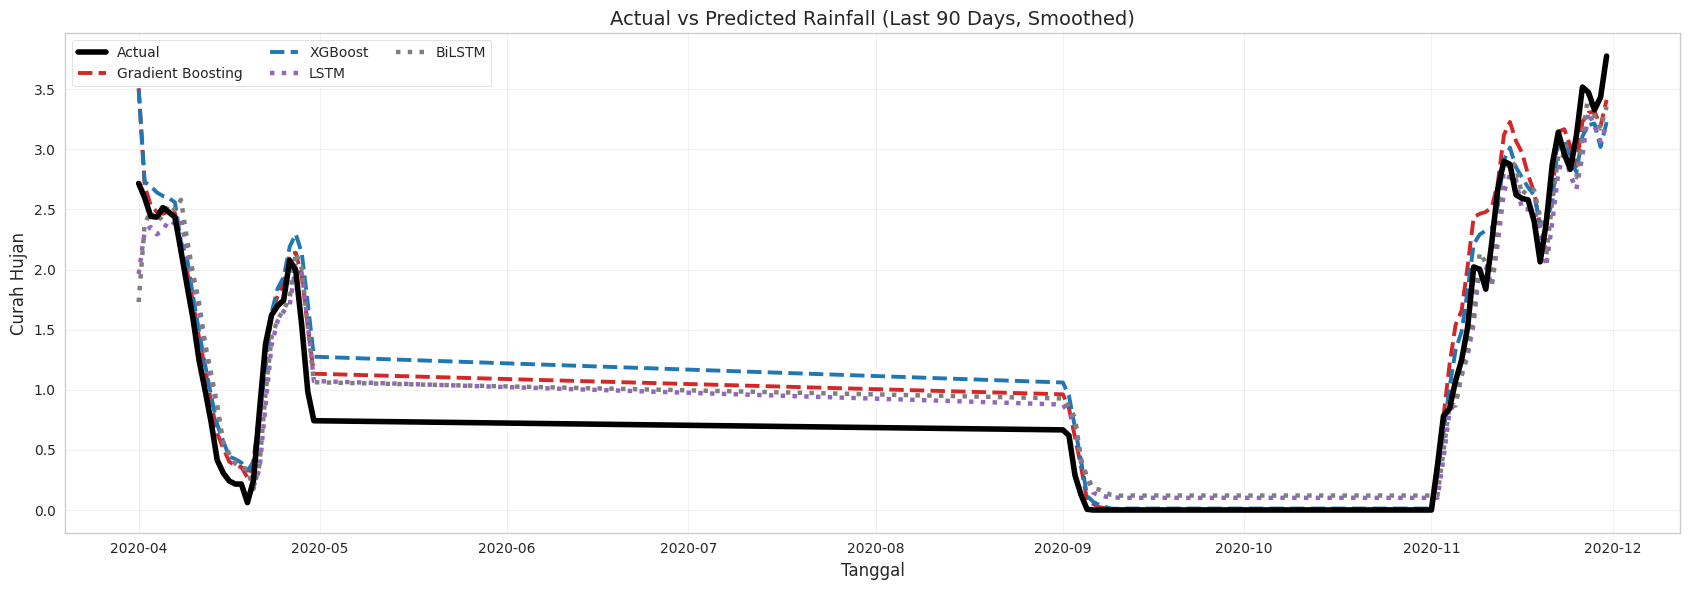

In [39]:
WINDOW = 90
SMOOTH = 7

# Get dates from the test data
# For tabular models, use .loc with original index (not .iloc!)
dates_test_tabular = df_clean.loc[X_test.index, 'tanggal'].values

# For sequence data, calculate dates based on test split
# The sequence test data starts after 80% of the sequence data
n_seq_total = len(X_seq)
n_seq_train = len(X_tr)
dates_all = df_clean['tanggal'].values[SEQ_LEN:]  # Offset by SEQ_LEN
dates_test_seq = dates_all[n_seq_train:]

# Get predictions (already computed in 9.2)
pred_gbr = gbr_model.predict(X_test_scaled)
pred_xgb = xgb_model.predict(X_test_scaled.values)
# pred_lstm and pred_bilstm already defined in 9.2 with inverse_transform

# Use minimum of WINDOW and available data
window_tab = min(WINDOW, len(dates_test_tabular))
window_seq = min(WINDOW, len(dates_test_seq))

dates_tab = dates_test_tabular[-window_tab:]
dates_seq = dates_test_seq[-window_seq:]

y_actual = y_test.values[-window_tab:]

pred_gbr_w = pred_gbr[-window_tab:]
pred_xgb_w = pred_xgb[-window_tab:]
pred_lstm_w = pred_lstm[-window_seq:]
pred_bilstm_w = pred_bilstm[-window_seq:]

def smooth(x, w=SMOOTH):
    return pd.Series(x).rolling(w, min_periods=1).mean()

plt.figure(figsize=(17, 6))

# ===== ACTUAL =====
plt.plot(
    dates_tab,
    smooth(y_actual),
    label="Actual",
    color="black",
    linewidth=4,
    zorder=10
)

# ===== TABULAR MODELS =====
plt.plot(
    dates_tab,
    smooth(pred_gbr_w),
    label="Gradient Boosting",
    color="#D62728",        # merah
    linestyle="--",
    linewidth=2.8
)

plt.plot(
    dates_tab,
    smooth(pred_xgb_w),
    label="XGBoost",
    color="#1F77B4",        # biru
    linestyle="--",
    linewidth=2.8
)

# ===== DEEP LEARNING MODELS =====
plt.plot(
    dates_seq,
    smooth(pred_lstm_w),
    label="LSTM",
    color="#9467BD",        # ungu
    linestyle=":",
    linewidth=3.2
)

plt.plot(
    dates_seq,
    smooth(pred_bilstm_w),
    label="BiLSTM",
    color="#7F7F7F",        # abu gelap
    linestyle=":",
    linewidth=3.2
)

plt.title("Actual vs Predicted Rainfall (Last 90 Days, Smoothed)", fontsize=14)
plt.xlabel("Tanggal")
plt.ylabel("Curah Hujan")

plt.legend(
    ncol=3,
    frameon=True,
    fontsize=10
)

plt.grid(alpha=0.25)
plt.tight_layout()
plt.show()

## 10. Hyperparameter Tuning (Scikit-Learn)

In [40]:
# GridSearchCV untuk Gradient Boosting
param_grid_gbr = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1]
}

grid_gbr = GridSearchCV(
    GradientBoostingRegressor(random_state=42),
    param_grid_gbr,
    cv=3,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

grid_gbr.fit(X_train_scaled, y_train)

print(f'Best Parameters: {grid_gbr.best_params_}')
print(f'Best Score (neg MSE): {grid_gbr.best_score_:.4f}')

# Evaluate tuned model
best_gbr = grid_gbr.best_estimator_
pred_best_gbr = best_gbr.predict(X_test_scaled)

print('=== Tuned Gradient Boosting Performance ===')
print(f"MAE: {mean_absolute_error(y_test, pred_best_gbr):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, pred_best_gbr)):.4f}")
print(f"R2: {r2_score(y_test, pred_best_gbr):.4f}")

Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 150}
Best Score (neg MSE): -0.2698
=== Tuned Gradient Boosting Performance ===
MAE: 0.3069
RMSE: 0.5407
R2: 0.8694


## 11. Export Models

### 11.1 Export ke PKL (Scikit-Learn)

In [41]:
joblib.dump(lr_model, 'model_lr.pkl')
joblib.dump(gbr_model, 'model_gbr.pkl')
joblib.dump(best_gbr, 'model_gbr_tuned.pkl')
joblib.dump(xgb_model, 'model_xgb.pkl')

# IMPORTANT: Export scalers for inference
joblib.dump(feature_scaler, 'feature_scaler.pkl')
joblib.dump(target_scaler, 'target_scaler.pkl')

print('PKL models exported: model_lr.pkl, model_gbr.pkl, model_gbr_tuned.pkl, model_xgb.pkl')
print('Scalers exported: feature_scaler.pkl, target_scaler.pkl')

PKL models exported: model_lr.pkl, model_gbr.pkl, model_gbr_tuned.pkl, model_xgb.pkl
Scalers exported: feature_scaler.pkl, target_scaler.pkl


### 11.2 Export ke Keras Format (TensorFlow)

In [42]:
lstm_model.save('model_lstm.keras')
bilstm_model.save('model_bilstm.keras')

print('Keras models exported: model_lstm.keras, model_bilstm.keras')

Keras models exported: model_lstm.keras, model_bilstm.keras


### 11.3 Convert ke ONNX

In [43]:
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType
import tf2onnx

# Convert Gradient Boosting ke ONNX (using scaled feature shape)
initial_type = [('input', FloatTensorType([None, X_train_scaled.shape[1]]))]
onnx_gbr = convert_sklearn(gbr_model, initial_types=initial_type)
with open('model_gbr.onnx', 'wb') as f:
    f.write(onnx_gbr.SerializeToString())
print('✅ model_gbr.onnx exported')

# Convert XGBoost ke ONNX
try:
    from onnxmltools import convert_xgboost
    from onnxmltools.convert.common.data_types import FloatTensorType as FTT

    onnx_xgb = convert_xgboost(
        xgb_model,
        initial_types=[('input', FTT([None, X_train_scaled.shape[1]]))],
        target_opset=12  # Compatible with ONNX Runtime Web
    )
    with open('model_xgb.onnx', 'wb') as f:
        f.write(onnx_xgb.SerializeToString())
    print('✅ model_xgb.onnx exported')
except Exception as e:
    print(f'⚠️ XGBoost ONNX failed: {e}')
    print('Saving XGBoost as pickle instead...')
    joblib.dump(xgb_model, 'model_xgb.pkl')

# LSTM → ONNX
@tf.function(
    input_signature=[tf.TensorSpec((None, SEQ_LEN, 1), tf.float32, name="input")]
)
def lstm_onnx_fn(x):
    return lstm_model(x)

tf2onnx.convert.from_function(
    lstm_onnx_fn,
    input_signature=[tf.TensorSpec((None, SEQ_LEN, 1), tf.float32, name="input")],
    output_path="model_lstm.onnx"
)

print("✅ model_lstm.onnx exported")

# BiLSTM → ONNX
@tf.function(
    input_signature=[tf.TensorSpec((None, SEQ_LEN, 1), tf.float32, name="input")]
)
def bilstm_onnx_fn(x):
    return bilstm_model(x)

tf2onnx.convert.from_function(
    bilstm_onnx_fn,
    input_signature=[tf.TensorSpec((None, SEQ_LEN, 1), tf.float32, name="input")],
    output_path="model_bilstm.onnx"
)

print("✅ model_bilstm.onnx exported")

✅ model_gbr.onnx exported
✅ model_xgb.onnx exported


ERROR:tf2onnx.tfonnx:rewriter <function rewrite_constant_fold at 0x7cffe84036a0>: exception `np.cast` was removed in the NumPy 2.0 release. Use `np.asarray(arr, dtype=dtype)` instead.


✅ model_lstm.onnx exported


ERROR:tf2onnx.tfonnx:rewriter <function rewrite_constant_fold at 0x7cffe84036a0>: exception `np.cast` was removed in the NumPy 2.0 release. Use `np.asarray(arr, dtype=dtype)` instead.


✅ model_bilstm.onnx exported


## 12. Inference (Menggunakan Model yang Sudah Diexport)

### 12.1 Inference dengan PKL Models

In [44]:
# Load exported models and scalers
lr_loaded = joblib.load('model_lr.pkl')
gbr_loaded = joblib.load('model_gbr.pkl')
xgb_loaded = joblib.load('model_xgb.pkl')
feature_scaler_loaded = joblib.load('feature_scaler.pkl')
target_scaler_loaded = joblib.load('target_scaler.pkl')

# Sample inference (must use SCALED features!)
sample = X_test_scaled.iloc[:5]
print('Sample Input (SCALED):')
print(sample)
print(f'\nLinear Regression Predictions: {lr_loaded.predict(sample)}')
print(f'Gradient Boosting Predictions: {gbr_loaded.predict(sample)}')
print(f'XGBoost Predictions: {xgb_loaded.predict(sample.values)}')

Sample Input (SCALED):
         lag_1     lag_3     lag_7  roll_mean_3  roll_mean_7  roll_max_7  \
1441  0.706572  1.113210  0.235747     1.433602     1.290785    1.565051   
1442  0.918568  2.458058  1.160943     1.025721     1.310791    1.565051   
1443  1.298634  0.704986  0.408273     1.311037     1.488690    1.565051   
1444  1.520180  0.916728  1.210236     1.457713     1.506850    1.565051   
1445  1.336831  1.296338  1.102170     1.235354     1.434212    1.565051   

      roll_std_7  bulan_idx  day_of_week  
1441    0.829775  -1.366861     1.499434  
1442    0.836777  -1.366861    -1.498737  
1443    0.616393  -1.366861    -0.999042  
1444    0.612128  -1.366861    -0.499347  
1445    0.752326  -1.366861     0.000348  

Linear Regression Predictions: [5.14452317 2.68214076 4.3040062  4.2625083  3.53283235]
Gradient Boosting Predictions: [5.2914067  2.24683763 4.16937922 4.43455946 3.35068504]
XGBoost Predictions: [4.8850055 2.486563  4.0502424 4.279392  3.3203566]


### 12.2 Inference dengan Keras Models

In [34]:
# Load Keras models
lstm_loaded = tf.keras.models.load_model('model_lstm.keras')
bilstm_loaded = tf.keras.models.load_model('model_bilstm.keras')

# Sample inference
sample_seq = X_te[:5]
print('Sample Sequence Shape:', sample_seq.shape)
print(f'LSTM Predictions: {lstm_loaded.predict(sample_seq).ravel()}')
print(f'BiLSTM Predictions: {bilstm_loaded.predict(sample_seq).ravel()}')

Sample Sequence Shape: (5, 7, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step
LSTM Predictions: [0.92592746 1.3141172  1.4649712  1.2311424  0.5958917 ]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step
BiLSTM Predictions: [1.1615657 1.5369116 1.5138917 1.2715478 0.6413165]


## 13. Cek Status Prediksi (Model Asli vs ONNX)

In [46]:
import onnxruntime as ort

TOL = 1e-4

print('=' * 50)
print('SYNC TEST: Python Model vs ONNX Model')
print('=' * 50)

# Test Gradient Boosting (using SCALED features)
print('\n🔹 Gradient Boosting')
pred_gbr_py = gbr_model.predict(X_test_scaled)

sess_gbr = ort.InferenceSession('model_gbr.onnx')
pred_gbr_onnx = sess_gbr.run(None, {'input': X_test_scaled.values.astype(np.float32)})[0].ravel()

diff_gbr = np.abs(pred_gbr_py - pred_gbr_onnx)
print(f'Max abs diff: {diff_gbr.max():.6f}')
print(f'Mean abs diff: {diff_gbr.mean():.6f}')
print(f'STATUS: {"✅ PASS" if diff_gbr.max() < TOL else "❌ FAIL"}')

# Test XGBoost (using SCALED features as numpy array)
print('\n🔹 XGBoost')
try:
    pred_xgb_py = xgb_model.predict(X_test_scaled.values)

    sess_xgb = ort.InferenceSession('model_xgb.onnx')
    pred_xgb_onnx = sess_xgb.run(None, {'input': X_test_scaled.values.astype(np.float32)})[0].ravel()

    diff_xgb = np.abs(pred_xgb_py - pred_xgb_onnx)
    print(f'Max abs diff: {diff_xgb.max():.6f}')
    print(f'Mean abs diff: {diff_xgb.mean():.6f}')
    print(f'STATUS: {"✅ PASS" if diff_xgb.max() < TOL else "❌ FAIL"}')
except Exception as e:
    print(f'⚠️ XGBoost ONNX test skipped: {e}')

# Test LSTM
print('\n🔹 LSTM')
pred_lstm_py = lstm_model.predict(X_te).ravel()

sess_lstm = ort.InferenceSession('model_lstm.onnx')
pred_lstm_onnx = sess_lstm.run(None, {'input': X_te.astype(np.float32)})[0].ravel()

diff_lstm = np.abs(pred_lstm_py - pred_lstm_onnx)
print(f'Max abs diff: {diff_lstm.max():.6f}')
print(f'Mean abs diff: {diff_lstm.mean():.6f}')
print(f'STATUS: {"✅ PASS" if diff_lstm.max() < TOL else "❌ FAIL"}')

# Test BiLSTM
print('\n🔹 BiLSTM')
pred_bilstm_py = bilstm_model.predict(X_te).ravel()

sess_bilstm = ort.InferenceSession('model_bilstm.onnx')
pred_bilstm_onnx = sess_bilstm.run(None, {'input': X_te.astype(np.float32)})[0].ravel()

diff_bilstm = np.abs(pred_bilstm_py - pred_bilstm_onnx)
print(f'Max abs diff: {diff_bilstm.max():.6f}')
print(f'Mean abs diff: {diff_bilstm.mean():.6f}')
print(f'STATUS: {"✅ PASS" if diff_bilstm.max() < TOL else "❌ FAIL"}')

print('\n' + '=' * 50)
print('SYNC TEST COMPLETED')
print('=' * 50)

SYNC TEST: Python Model vs ONNX Model

🔹 Gradient Boosting
Max abs diff: 0.000001
Mean abs diff: 0.000000
STATUS: ✅ PASS

🔹 XGBoost
Max abs diff: 0.000004
Mean abs diff: 0.000000
STATUS: ✅ PASS

🔹 LSTM
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Max abs diff: 0.000000
Mean abs diff: 0.000000
STATUS: ✅ PASS

🔹 BiLSTM
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Max abs diff: 0.000001
Mean abs diff: 0.000000
STATUS: ✅ PASS

SYNC TEST COMPLETED
